In [1]:
import torch
import torchaudio
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score


cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("hvcm/RFQ.npy", allow_pickle=True)
label = np.load("hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]



NVIDIA A30
(872, 4500, 14) (872,)


# Processing: Mel Spec > Resizing > Feature Extraction

In [2]:
def resize_spectrogram(spectrogram, global_min=None, global_max=None):
    """
    Improved spectrogram processing with consistent normalization
    """
    # Use global min/max for consistent normalization across all spectrograms
    if global_min is not None and global_max is not None:
        spectrogram = (spectrogram - global_min) / (global_max - global_min + 1e-8)
    else:
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-8)
    
    # Clip to [0,1] and convert to uint8
    spectrogram = np.clip(spectrogram, 0, 1)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

def process_dataset_improved(data, sample_rate=1000):  # More reasonable sample rate
    """
    Improved dataset processing with better mel-spectrogram parameters
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    
    # Better mel-spectrogram parameters for sensor data
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,          # Reasonable FFT size
        hop_length=256,     # 50% overlap
        win_length=512,
        window_fn=torch.hann_window
    ).to(device)
    
    # Load VGG16 model
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    # Compute global min/max for consistent normalization
    print("Computing global spectrogram statistics...")
    all_mels = []
    for i in range(min(100, num_samples)):  # Sample subset for statistics
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            all_mels.append(mel.cpu().numpy())
    
    all_mels = np.concatenate([mel.flatten() for mel in all_mels])
    global_min, global_max = np.percentile(all_mels, [1, 99])  # Use percentiles to avoid outliers
    
    print(f"Processing {num_samples} samples...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
            
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Use consistent normalization
            img = resize_spectrogram(mel, global_min, global_max)
            
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    
    return features

# Alternative: Multi-channel processing
def process_dataset_multichannel(data, sample_rate=1000):
    """
    Process multiple channels together to capture cross-channel relationships
    """
    num_samples, _, num_channels = data.shape
    features = np.zeros((num_samples, 4096))  # Single feature vector per sample
    
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,
        hop_length=256,
        win_length=512
    ).to(device)
    
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    print(f"Processing {num_samples} samples with multi-channel approach...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
        
        # Combine multiple channels into RGB image
        channel_spectrograms = []
        for j in range(min(3, num_channels)):  # Use first 3 channels as RGB
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Normalize each channel spectrogram
            mel_norm = (mel - mel.min()) / (mel.max() - mel.min() + 1e-8)
            mel_resized = torch.nn.functional.interpolate(
                mel_norm.unsqueeze(0).unsqueeze(0), 
                size=(224, 224), 
                mode='bilinear'
            ).squeeze()
            channel_spectrograms.append(mel_resized.cpu().numpy())
        
        # Stack as RGB image
        if len(channel_spectrograms) == 1:
            rgb_img = np.stack([channel_spectrograms[0]] * 3, axis=0)
        elif len(channel_spectrograms) == 2:
            rgb_img = np.stack([channel_spectrograms[0], channel_spectrograms[1], channel_spectrograms[0]], axis=0)
        else:
            rgb_img = np.stack(channel_spectrograms[:3], axis=0)
        
        img_tensor = torch.tensor(rgb_img, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            feat = model(img_tensor)
        features[i, :] = feat.squeeze().cpu().numpy()
    
    return features

# AE Class

In [3]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
            nn.Tanh(),
            nn.Linear(32, 16), 
            nn.Tanh(),
            nn.Linear(16, 8), 
            nn.Tanh(),
            nn.Linear(8, 4), 
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.Tanh(),
            nn.Linear(8, 16), 
            nn.Tanh(),
            nn.Linear(16, 32), 
            nn.Tanh(),
            nn.Linear(32, 64), 
            nn.Tanh(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Add weight decay
    criterion = nn.MSELoss()  # Try MSE instead of L1

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            # Add noise for denoising autoencoder
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)  # Reconstruct clean from noisy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data, add_noise=True):
    """
    Compute reconstruction loss per sample (not per segment)
    data: shape (n_samples, n_channels, 4096)
    """
    model.eval()
    n_samples, n_channels, n_features = data.shape
    sample_errors = []
    
    # Flatten to (n_samples*n_channels, 4096) for batch processing
    x = torch.tensor(data.reshape(-1, n_features), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    
    all_errors = []
    criterion = torch.nn.MSELoss(reduction='none')
    
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            
            if add_noise:
                noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
                outputs = model(noisy_inputs)
            else:
                outputs = model(inputs)
            
            # Per-segment reconstruction error
            segment_errors = criterion(outputs, inputs).mean(dim=1)
            all_errors.extend(segment_errors.cpu().numpy())
    
    # Reshape back to (n_samples, n_channels) and aggregate per sample
    all_errors = np.array(all_errors).reshape(n_samples, n_channels)
    sample_errors = all_errors.mean(axis=1)  # Average across channels per sample
    
    return sample_errors

# ===============================
# THRESHOLD-BASED METHODS
# ===============================

def find_best_threshold_f1(errors, labels):
    """Find best threshold based on F1 score"""
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def find_best_threshold_accuracy(errors, labels):
    """Find best threshold based on accuracy"""
    best_acc = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        acc = accuracy_score(labels, preds)
        if acc > best_acc:
            best_acc = acc
            best_threshold = threshold
    return best_threshold, best_acc

def find_threshold_percentile(errors, percentile=95):
    """Find threshold based on percentile of normal errors"""
    threshold = np.percentile(errors, percentile)
    return threshold

def evaluate_threshold_method(errors, labels, threshold):
    """Evaluate threshold-based method"""
    preds = (errors > threshold).astype(int)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds),
        'f1': f1_score(labels, preds),
        'predictions': preds
    }

# ===============================
# ONE-CLASS SVM METHODS
# ===============================

def train_one_class_svm(normal_errors, kernel='rbf', nu=0.1, gamma='scale'):
    """Train One-Class SVM on normal reconstruction errors"""
    normal_errors_2d = normal_errors.reshape(-1, 1)
    oc_svm = OneClassSVM(kernel=kernel, nu=nu, gamma=gamma)
    oc_svm.fit(normal_errors_2d)
    return oc_svm

def predict_with_one_class_svm(oc_svm, test_errors):
    """Predict anomalies using trained One-Class SVM"""
    test_errors_2d = test_errors.reshape(-1, 1)
    predictions = oc_svm.predict(test_errors_2d)
    binary_predictions = (predictions == -1).astype(int)
    return binary_predictions

def optimize_one_class_svm_parameters(normal_errors, faulty_errors, param_grid=None):
    """Optimize One-Class SVM parameters using grid search"""
    if param_grid is None:
        param_grid = {
            'kernel': ['rbf', 'poly', 'sigmoid'],
            'nu': [0.05, 0.1, 0.15, 0.2],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1.0]
        }
    
    best_f1 = 0
    best_params = None
    
    print("Optimizing One-Class SVM parameters...")
    
    val_errors = np.concatenate([normal_errors, faulty_errors])
    val_labels = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(faulty_errors))])
    
    total_combinations = len(param_grid['kernel']) * len(param_grid['nu']) * len(param_grid['gamma'])
    current_combination = 0
    
    for kernel in param_grid['kernel']:
        for nu in param_grid['nu']:
            for gamma in param_grid['gamma']:
                current_combination += 1
                
                try:
                    oc_svm = train_one_class_svm(normal_errors, kernel=kernel, nu=nu, gamma=gamma)
                    predictions = predict_with_one_class_svm(oc_svm, val_errors)
                    f1 = f1_score(val_labels, predictions)
                    
                    if f1 > best_f1:
                        best_f1 = f1
                        best_params = {'kernel': kernel, 'nu': nu, 'gamma': gamma}
                    
                    if current_combination % 10 == 0:
                        print(f"Progress: {current_combination}/{total_combinations} - Current F1: {f1:.4f}, Best F1: {best_f1:.4f}")
                
                except Exception as e:
                    print(f"Error with params kernel={kernel}, nu={nu}, gamma={gamma}: {e}")
                    continue
    
    print(f"Best parameters: {best_params}")
    print(f"Best F1 score: {best_f1:.4f}")
    
    return best_params, best_f1

def evaluate_one_class_svm(oc_svm, test_errors, test_labels):
    """Evaluate One-Class SVM method"""
    preds = predict_with_one_class_svm(oc_svm, test_errors)
    return {
        'accuracy': accuracy_score(test_labels, preds),
        'precision': precision_score(test_labels, preds),
        'recall': recall_score(test_labels, preds),
        'f1': f1_score(test_labels, preds),
        'predictions': preds
    }

# ===============================
# COMPREHENSIVE EVALUATION
# ===============================

def comprehensive_anomaly_detection_evaluation(model, normal_train_data, faulty_train_data, 
                                              test_data, test_labels, fold_num):
    """
    Comprehensive evaluation of all anomaly detection methods
    """
    print(f"\n{'='*20} FOLD {fold_num} EVALUATION {'='*20}")
    
    # Compute reconstruction errors
    train_errors_normal = compute_reconstruction_loss(model, normal_train_data)
    train_errors_faulty = compute_reconstruction_loss(model, faulty_train_data)
    test_errors = compute_reconstruction_loss(model, test_data)
    
    # Combine training errors for validation
    val_errors = np.concatenate([train_errors_normal, train_errors_faulty])
    val_labels = np.concatenate([np.zeros(len(train_errors_normal)), np.ones(len(train_errors_faulty))])
    
    results = {}
    
    # ===============================
    # METHOD 1: Threshold based on F1 Score
    # ===============================
    print("\n1. Threshold Method - F1 Score Optimization")
    threshold_f1, best_f1_val = find_best_threshold_f1(val_errors, val_labels)
    print(f"   Best threshold: {threshold_f1:.6f}, Validation F1: {best_f1_val:.4f}")
    results['threshold_f1'] = evaluate_threshold_method(test_errors, test_labels, threshold_f1)
    
    # ===============================
    # METHOD 2: Threshold based on Accuracy
    # ===============================
    print("\n2. Threshold Method - Accuracy Optimization")
    threshold_acc, best_acc_val = find_best_threshold_accuracy(val_errors, val_labels)
    print(f"   Best threshold: {threshold_acc:.6f}, Validation Accuracy: {best_acc_val:.4f}")
    results['threshold_accuracy'] = evaluate_threshold_method(test_errors, test_labels, threshold_acc)
    
    # ===============================
    # METHOD 3: Threshold based on Percentile (95th)
    # ===============================
    print("\n3. Threshold Method - 95th Percentile")
    threshold_95 = find_threshold_percentile(train_errors_normal, percentile=95)
    print(f"   95th percentile threshold: {threshold_95:.6f}")
    results['threshold_95th'] = evaluate_threshold_method(test_errors, test_labels, threshold_95)
    
    # ===============================
    # METHOD 4: One-Class SVM
    # ===============================
    print("\n4. One-Class SVM Method")
    best_params, best_f1_svm = optimize_one_class_svm_parameters(train_errors_normal, train_errors_faulty)
    oc_svm = train_one_class_svm(
        train_errors_normal,
        kernel=best_params['kernel'],
        nu=best_params['nu'],
        gamma=best_params['gamma']
    )
    results['one_class_svm'] = evaluate_one_class_svm(oc_svm, test_errors, test_labels)
    
    # Print fold results
    print(f"\n{'='*15} FOLD {fold_num} RESULTS SUMMARY {'='*15}")
    methods = ['threshold_f1', 'threshold_accuracy', 'threshold_95th', 'one_class_svm']
    method_names = ['Threshold (F1)', 'Threshold (Acc)', 'Threshold (95%)', 'One-Class SVM']
    
    for method, name in zip(methods, method_names):
        result = results[method]
        print(f"{name:18s} - Acc: {result['accuracy']:.4f}, Prec: {result['precision']:.4f}, "
              f"Rec: {result['recall']:.4f}, F1: {result['f1']:.4f}")
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Error distributions
    plt.subplot(1, 3, 1)
    plt.hist(train_errors_normal, bins=30, alpha=0.5, label='Normal', color='blue')
    plt.hist(train_errors_faulty, bins=30, alpha=0.5, label='Faulty', color='red')
    plt.axvline(threshold_f1, color='green', linestyle='--', label=f'F1 Threshold: {threshold_f1:.4f}')
    plt.axvline(threshold_acc, color='orange', linestyle='--', label=f'Acc Threshold: {threshold_acc:.4f}')
    plt.axvline(threshold_95, color='purple', linestyle='--', label=f'95% Threshold: {threshold_95:.4f}')
    plt.title(f'Fold {fold_num}: Error Distributions')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Method comparison - Accuracy
    plt.subplot(1, 3, 2)
    accuracies = [results[method]['accuracy'] for method in methods]
    plt.bar(method_names, accuracies, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
    plt.title(f'Fold {fold_num}: Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Method comparison - F1 Score
    plt.subplot(1, 3, 3)
    f1_scores = [results[method]['f1'] for method in methods]
    plt.bar(method_names, f1_scores, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
    plt.title(f'Fold {fold_num}: F1 Score Comparison')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results


# Cross Validation

## Comprehensive Anomaly Detection Methods Comparison

**Methods Tested:**
1. **Threshold (F1 Optimization)**: Find best threshold to maximize F1 score
2. **Threshold (Accuracy Optimization)**: Find best threshold to maximize accuracy  
3. **Threshold (95th Percentile)**: Use 95th percentile of normal errors as threshold
4. **One-Class SVM**: Support vector approach with parameter optimization

**Evaluation Metrics:**
- Accuracy, Precision, Recall, F1 Score
- Cross-validation with 5 folds
- Statistical analysis with mean ± standard deviation
- Comprehensive visualization and ranking

COMPREHENSIVE ANOMALY DETECTION METHODS COMPARISON
Testing 4 methods:
1. Threshold optimization using F1 Score
2. Threshold optimization using Accuracy
3. Threshold using 95th percentile of normal errors
4. One-Class SVM with parameter optimization

============================== FOLD 1 ==============================
Processing datasets...
Processing 552 samples with multi-channel approach...
Processed 0/552 samples
Processing 552 samples with multi-channel approach...
Processed 0/552 samples
Processed 100/552 samples
Processed 100/552 samples
Processed 200/552 samples
Processed 200/552 samples
Processed 300/552 samples
Processed 300/552 samples
Processed 400/552 samples
Processed 400/552 samples
Processed 500/552 samples
Processed 500/552 samples
Processing 145 samples with multi-channel approach...
Processed 0/145 samples
Processing 145 samples with multi-channel approach...
Processed 0/145 samples
Processed 100/145 samples
Processed 100/145 samples
Processing 138 samples with multi-

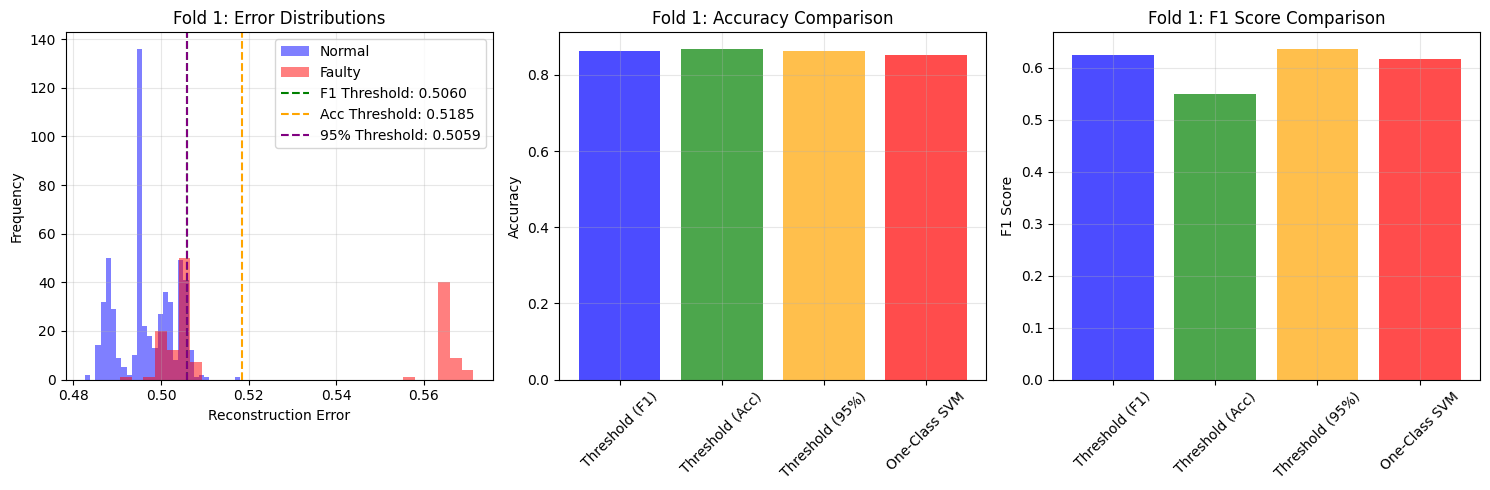


============================== FOLD 2 ==============================
Processing datasets...
Processing 552 samples with multi-channel approach...
Processed 0/552 samples
Processing 552 samples with multi-channel approach...
Processed 0/552 samples
Processed 100/552 samples
Processed 100/552 samples
Processed 200/552 samples
Processed 200/552 samples
Processed 300/552 samples
Processed 300/552 samples
Processed 400/552 samples
Processed 400/552 samples
Processed 500/552 samples
Processed 500/552 samples
Processing 145 samples with multi-channel approach...
Processed 0/145 samples
Processing 145 samples with multi-channel approach...
Processed 0/145 samples
Processed 100/145 samples
Processed 100/145 samples
Processing 138 samples with multi-channel approach...
Processed 0/138 samples
Processing 138 samples with multi-channel approach...
Processed 0/138 samples
Processed 100/138 samples
Processed 100/138 samples
Processing 37 samples with multi-channel approach...
Processed 0/37 samples

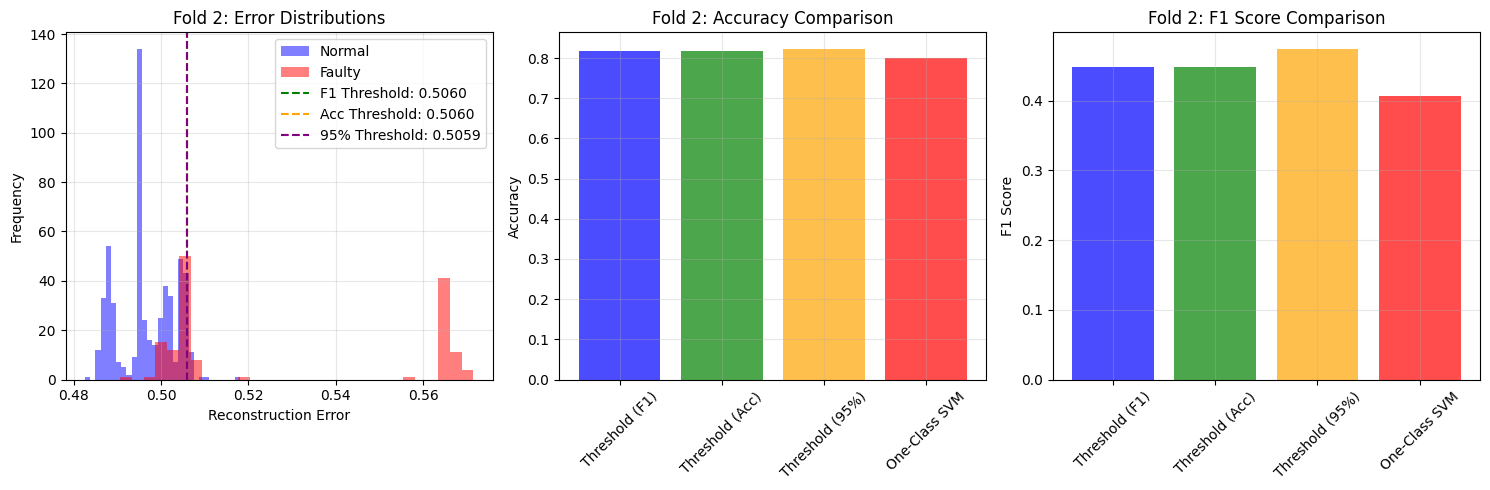


============================== FOLD 3 ==============================
Processing datasets...
Processing 552 samples with multi-channel approach...
Processed 0/552 samples
Processing 552 samples with multi-channel approach...
Processed 0/552 samples
Processed 100/552 samples
Processed 100/552 samples
Processed 200/552 samples
Processed 200/552 samples
Processed 300/552 samples
Processed 300/552 samples
Processed 400/552 samples
Processed 400/552 samples
Processed 500/552 samples
Processed 500/552 samples
Processing 145 samples with multi-channel approach...
Processed 0/145 samples
Processing 145 samples with multi-channel approach...
Processed 0/145 samples
Processed 100/145 samples
Processed 100/145 samples
Processing 138 samples with multi-channel approach...
Processed 0/138 samples
Processing 138 samples with multi-channel approach...
Processed 0/138 samples
Processed 100/138 samples
Processed 100/138 samples
Processing 37 samples with multi-channel approach...
Processed 0/37 samples

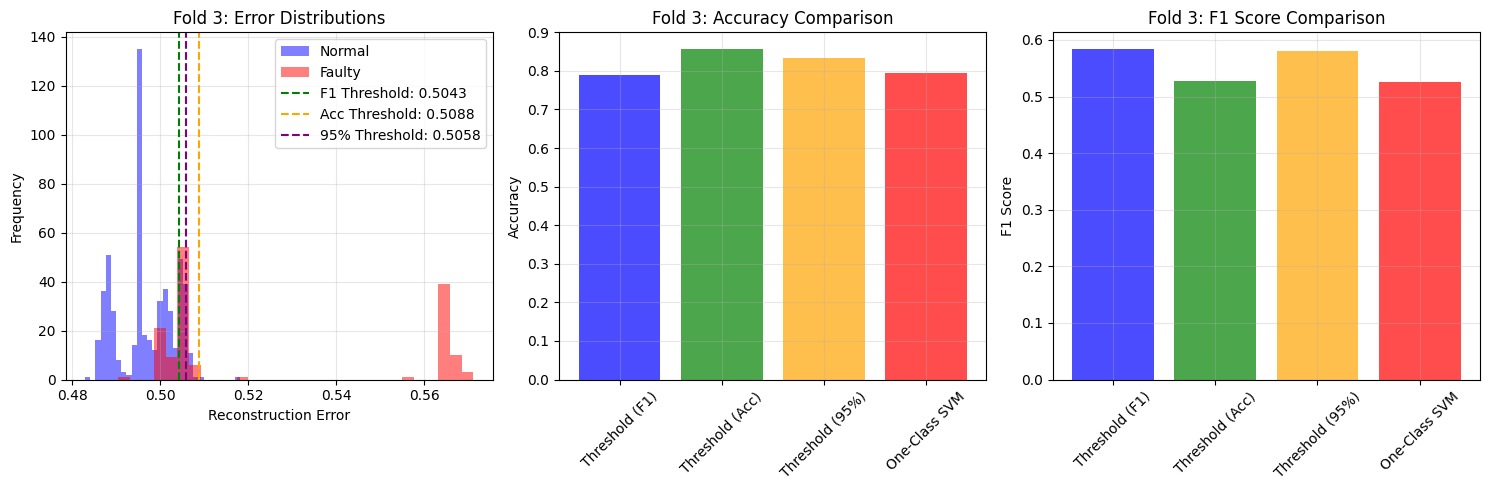


============================== FOLD 4 ==============================
Processing datasets...
Processing 552 samples with multi-channel approach...
Processed 0/552 samples
Processing 552 samples with multi-channel approach...
Processed 0/552 samples
Processed 100/552 samples
Processed 100/552 samples
Processed 200/552 samples
Processed 200/552 samples
Processed 300/552 samples
Processed 300/552 samples
Processed 400/552 samples
Processed 400/552 samples
Processed 500/552 samples
Processed 500/552 samples
Processing 145 samples with multi-channel approach...
Processed 0/145 samples
Processing 145 samples with multi-channel approach...
Processed 0/145 samples
Processed 100/145 samples
Processed 100/145 samples
Processing 138 samples with multi-channel approach...
Processed 0/138 samples
Processing 138 samples with multi-channel approach...
Processed 0/138 samples
Processed 100/138 samples
Processed 100/138 samples
Processing 37 samples with multi-channel approach...
Processed 0/37 samples

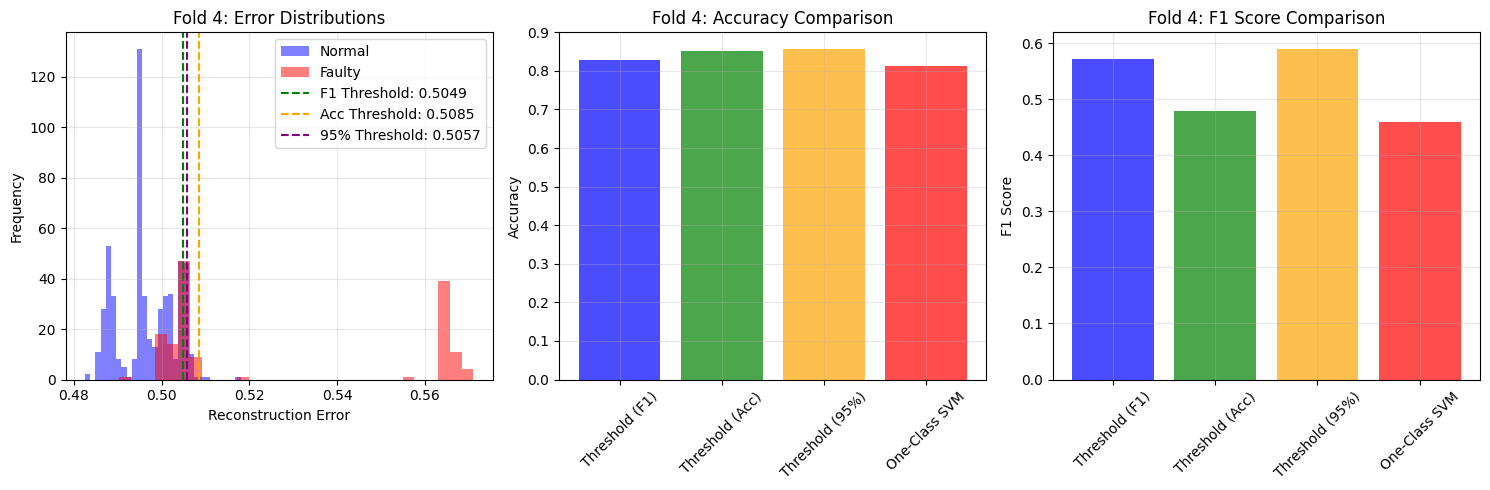


============================== FOLD 5 ==============================
Processing datasets...
Processing 552 samples with multi-channel approach...
Processed 0/552 samples
Processing 552 samples with multi-channel approach...
Processed 0/552 samples
Processed 100/552 samples
Processed 100/552 samples
Processed 200/552 samples
Processed 200/552 samples
Processed 300/552 samples
Processed 300/552 samples
Processed 400/552 samples
Processed 400/552 samples
Processed 500/552 samples
Processed 500/552 samples
Processing 145 samples with multi-channel approach...
Processed 0/145 samples
Processing 145 samples with multi-channel approach...
Processed 0/145 samples
Processed 100/145 samples
Processed 100/145 samples
Processing 138 samples with multi-channel approach...
Processed 0/138 samples
Processing 138 samples with multi-channel approach...
Processed 0/138 samples
Processed 100/138 samples
Processed 100/138 samples
Processing 37 samples with multi-channel approach...
Processed 0/37 samples

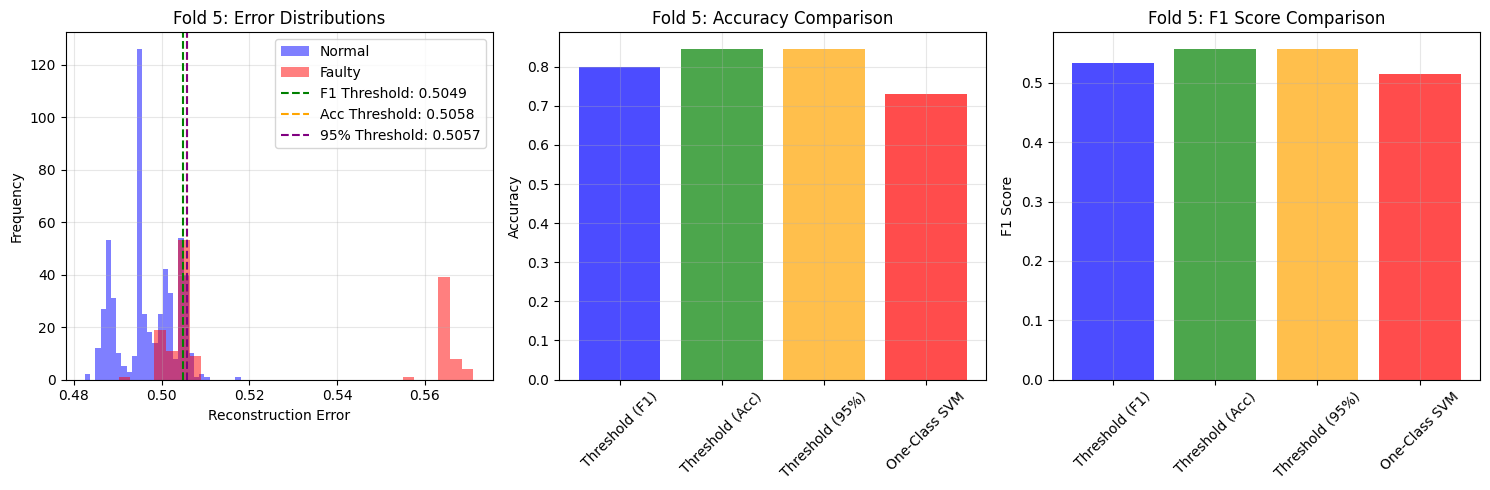


FINAL COMPREHENSIVE RESULTS ANALYSIS

AVERAGE PERFORMANCE ACROSS ALL FOLDS:

1. Threshold (F1 Opt):
---------------------
   Accuracy  : 0.8194 ± 0.0257
   Precision : 0.5984 ± 0.0844
   Recall    : 0.5351 ± 0.1113
   F1        : 0.5525 ± 0.0598

2. Threshold (Acc Opt):
----------------------
   Accuracy  : 0.8480 ± 0.0172
   Precision : 0.8251 ± 0.1406
   Recall    : 0.3784 ± 0.0452
   F1        : 0.5126 ± 0.0419

3. Threshold (95th %):
---------------------
   Accuracy  : 0.8446 ± 0.0146
   Precision : 0.6888 ± 0.0494
   Recall    : 0.4865 ± 0.0662
   F1        : 0.5676 ± 0.0532

4. One-Class SVM:
----------------
   Accuracy  : 0.7977 ± 0.0387
   Precision : 0.5471 ± 0.0854
   Recall    : 0.4973 ± 0.1286
   F1        : 0.5050 ± 0.0707

STATISTICAL COMPARISON TABLE
Method               Accuracy     Precision    Recall       F1 Score    
--------------------------------------------------------------------
Threshold (F1 Opt)   0.819±0.026  0.598±0.084  0.535±0.111  0.552±0.060
Thresho

/tmp/ipykernel_1137400/1527071115.py:174: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(method_names, rotation=45, ha='right')


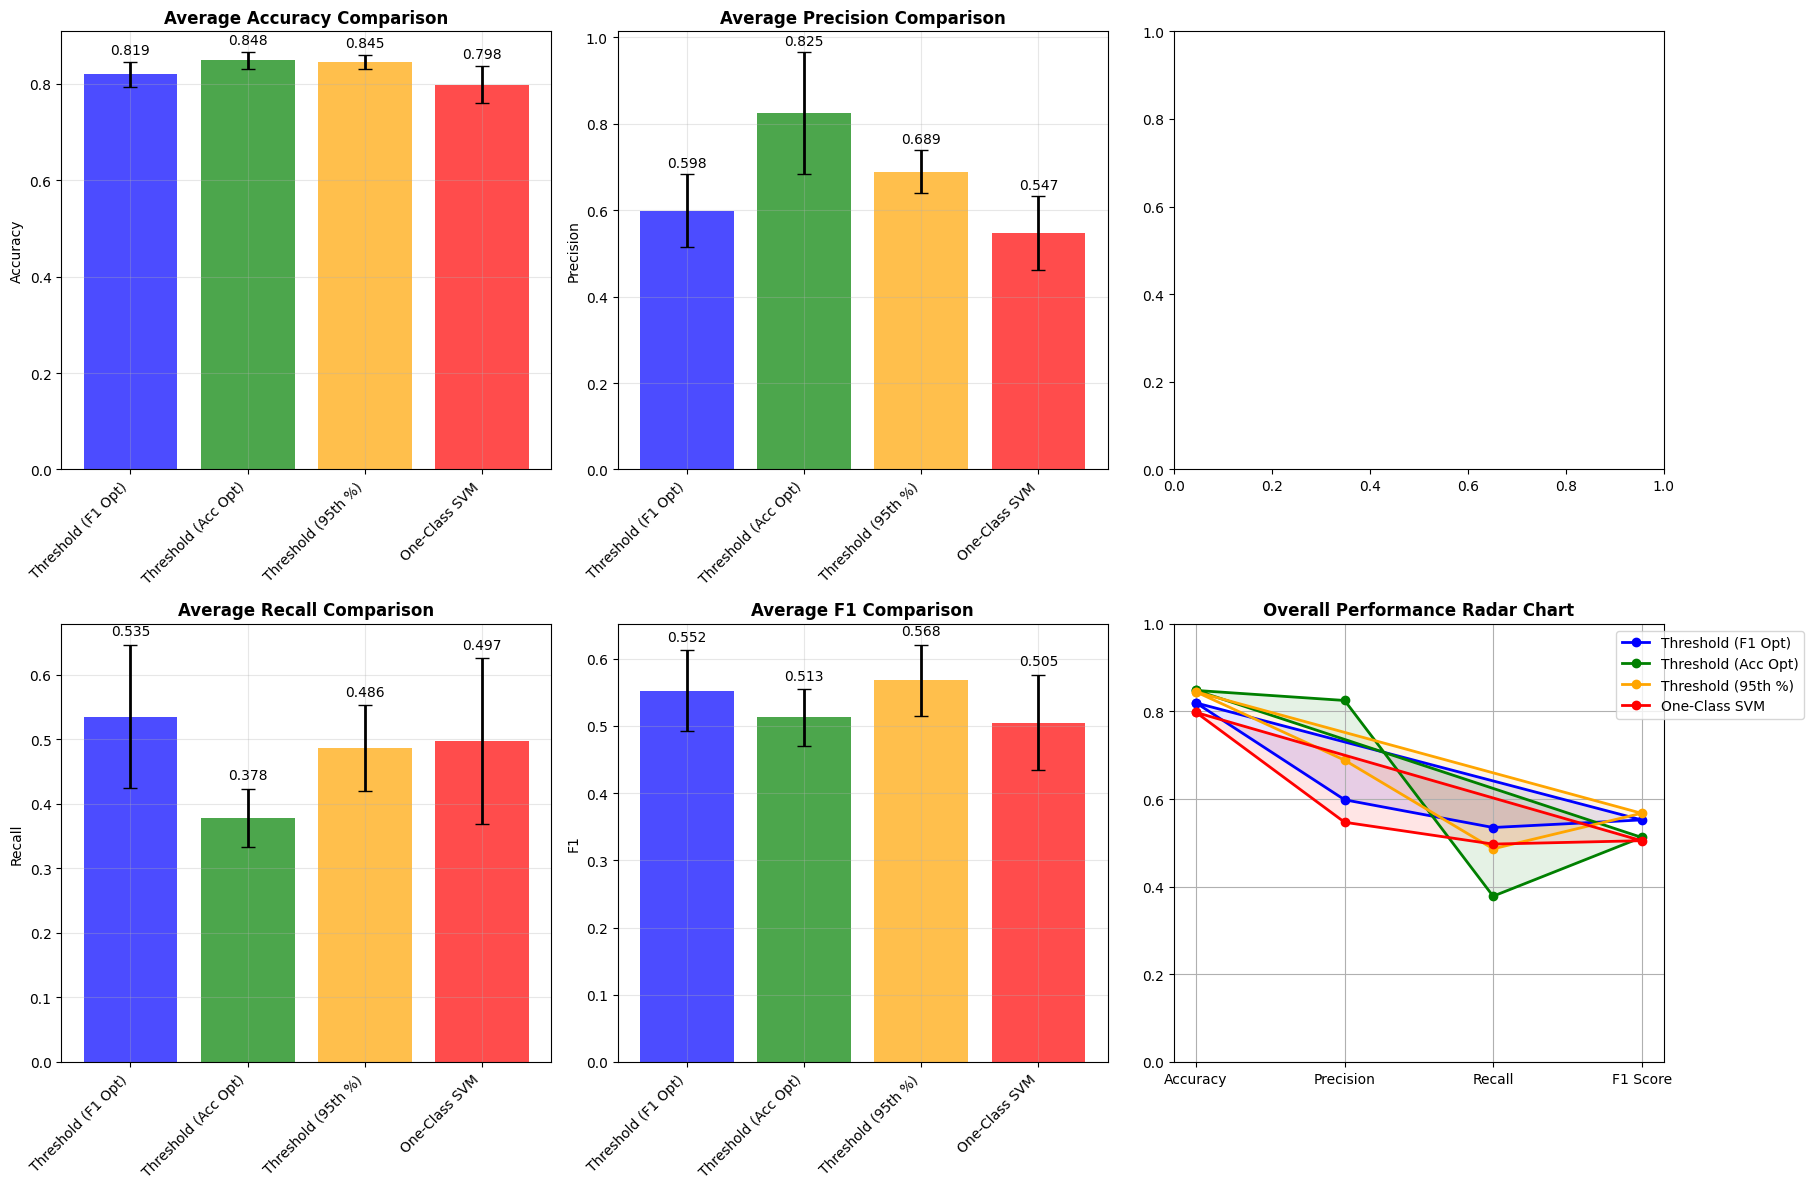


FINAL RECOMMENDATIONS

🏆 OVERALL BEST METHOD: Threshold (95th %)
   Average Score: 0.6469

📊 METHOD RANKINGS (by average performance):
   1. Threshold (95th %): 0.6469
   2. Threshold (Acc Opt): 0.6410
   3. Threshold (F1 Opt): 0.6264
   4. One-Class SVM: 0.5868

💡 INSIGHTS:
   • Best for Accuracy: Threshold (Acc Opt)
   • Best for Precision: Threshold (Acc Opt)
   • Best for Recall: Threshold (F1 Opt)
   • Best for F1 Score: Threshold (95th %)

🔍 ONE-CLASS SVM vs THRESHOLD (F1) ANALYSIS:
   One-Class SVM F1: 0.5050 ± 0.0707
   Threshold (F1) F1: 0.5525 ± 0.0598
   ⚠️ Threshold-based approach performs better than One-Class SVM

EXPERIMENT COMPLETED SUCCESSFULLY!


In [4]:
acc = []
prec = []
rec = []
f1 = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ===============================
# COMPREHENSIVE CROSS-VALIDATION EXPERIMENT
# ===============================

# Initialize results storage
results_all_methods = {
    'threshold_f1': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'threshold_accuracy': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'threshold_95th': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'one_class_svm': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("="*80)
print("COMPREHENSIVE ANOMALY DETECTION METHODS COMPARISON")
print("="*80)
print("Testing 4 methods:")
print("1. Threshold optimization using F1 Score")
print("2. Threshold optimization using Accuracy")
print("3. Threshold using 95th percentile of normal errors")
print("4. One-Class SVM with parameter optimization")
print("="*80)

for fold, (train_idx, val_idx) in enumerate(skf.split(data, label)):
    print(f"\n{'='*30} FOLD {fold + 1} {'='*30}")
    random_state = fold + 1

    # Split data
    X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(
        normal_data, normal_label, test_size=0.2, shuffle=True, random_state=random_state)
    X_train_faulty, X_test_faulty, y_train_faulty, y_test_faulty = train_test_split(
        faulty_data, faulty_label, test_size=0.2, shuffle=True, random_state=random_state)
    
    # Process datasets
    print("Processing datasets...")
    X_train_normal_processed = process_dataset_multichannel(X_train_normal)
    X_train_faulty_processed = process_dataset_multichannel(X_train_faulty)
    X_test_normal_processed = process_dataset_multichannel(X_test_normal)
    X_test_faulty_processed = process_dataset_multichannel(X_test_faulty)
    
    # Train autoencoder on normal data only
    print("Training autoencoder...")
    model = train_autoencoder(X_train_normal_processed, epochs=15, batch_size=32)

    # Add channel dimension for reconstruction loss computation
    X_train_normal_processed = X_train_normal_processed[:, np.newaxis, :]
    X_train_faulty_processed = X_train_faulty_processed[:, np.newaxis, :]
    X_test_normal_processed = X_test_normal_processed[:, np.newaxis, :]
    X_test_faulty_processed = X_test_faulty_processed[:, np.newaxis, :]

    # Combine test data
    X_test_combined = np.concatenate((X_test_normal_processed, X_test_faulty_processed), axis=0)
    y_test_combined = np.concatenate((y_test_normal, y_test_faulty), axis=0)

    # Comprehensive evaluation
    fold_results = comprehensive_anomaly_detection_evaluation(
        model, X_train_normal_processed, X_train_faulty_processed, 
        X_test_combined, y_test_combined, fold + 1
    )
    
    # Store results
    for method in results_all_methods.keys():
        for metric in results_all_methods[method].keys():
            results_all_methods[method][metric].append(fold_results[method][metric])

# ===============================
# FINAL RESULTS ANALYSIS
# ===============================

print("\n" + "="*80)
print("FINAL COMPREHENSIVE RESULTS ANALYSIS")
print("="*80)

methods = ['threshold_f1', 'threshold_accuracy', 'threshold_95th', 'one_class_svm']
method_names = ['Threshold (F1 Opt)', 'Threshold (Acc Opt)', 'Threshold (95th %)', 'One-Class SVM']

# Calculate and display averages
print("\nAVERAGE PERFORMANCE ACROSS ALL FOLDS:")
print("="*60)

results_summary = {}
for i, (method, name) in enumerate(zip(methods, method_names)):
    results_summary[method] = {}
    print(f"\n{i+1}. {name}:")
    print("-" * (len(name) + 3))
    
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        values = results_all_methods[method][metric]
        mean_val = np.mean(values)
        std_val = np.std(values)
        results_summary[method][metric] = {'mean': mean_val, 'std': std_val}
        
        print(f"   {metric.capitalize():10s}: {mean_val:.4f} ± {std_val:.4f}")

# ===============================
# STATISTICAL COMPARISON
# ===============================

print("\n" + "="*60)
print("STATISTICAL COMPARISON TABLE")
print("="*60)

# Create comparison table
print(f"{'Method':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1 Score':<12}")
print("-" * 68)

for method, name in zip(methods, method_names):
    acc_mean = results_summary[method]['accuracy']['mean']
    acc_std = results_summary[method]['accuracy']['std']
    prec_mean = results_summary[method]['precision']['mean']
    prec_std = results_summary[method]['precision']['std']
    rec_mean = results_summary[method]['recall']['mean']
    rec_std = results_summary[method]['recall']['std']
    f1_mean = results_summary[method]['f1']['mean']
    f1_std = results_summary[method]['f1']['std']
    
    print(f"{name:<20} {acc_mean:.3f}±{acc_std:.3f}  {prec_mean:.3f}±{prec_std:.3f}  "
          f"{rec_mean:.3f}±{rec_std:.3f}  {f1_mean:.3f}±{f1_std:.3f}")

# ===============================
# BEST METHOD IDENTIFICATION
# ===============================

print("\n" + "="*60)
print("BEST METHOD IDENTIFICATION")
print("="*60)

metrics_to_check = ['accuracy', 'precision', 'recall', 'f1']
best_methods = {}

for metric in metrics_to_check:
    best_score = 0
    best_method = ""
    best_method_name = ""
    
    for method, name in zip(methods, method_names):
        score = results_summary[method][metric]['mean']
        if score > best_score:
            best_score = score
            best_method = method
            best_method_name = name
    
    best_methods[metric] = {'method': best_method, 'name': best_method_name, 'score': best_score}
    print(f"Best {metric.capitalize():<10}: {best_method_name} ({best_score:.4f})")

# ===============================
# COMPREHENSIVE VISUALIZATION
# ===============================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Average Performance Comparison
metrics_plot = ['accuracy', 'precision', 'recall', 'f1']
colors = ['blue', 'green', 'orange', 'red']

for i, metric in enumerate(metrics_plot):
    ax = axes[i//2, i%2] if i < 4 else None
    if ax is not None:
        means = [results_summary[method][metric]['mean'] for method in methods]
        stds = [results_summary[method][metric]['std'] for method in methods]
        
        bars = ax.bar(method_names, means, yerr=stds, capsize=5, 
                     color=colors, alpha=0.7, error_kw={'linewidth': 2})
        
        ax.set_title(f'Average {metric.capitalize()} Comparison', fontsize=12, fontweight='bold')
        ax.set_ylabel(metric.capitalize())
        ax.set_xticklabels(method_names, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, mean, std in zip(bars, means, stds):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01,
                   f'{mean:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 5: Radar Chart for Overall Performance
ax_radar = axes[1, 2]
ax_radar.set_title('Overall Performance Radar Chart', fontsize=12, fontweight='bold')

# Prepare data for radar chart
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
N = len(categories)

# Compute angles for each category
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the circle

# Plot for each method
for i, (method, name) in enumerate(zip(methods, method_names)):
    values = [results_summary[method][metric]['mean'] for metric in metrics_plot]
    values += values[:1]  # Complete the circle
    
    ax_radar.plot(angles, values, 'o-', linewidth=2, label=name, color=colors[i])
    ax_radar.fill(angles, values, alpha=0.1, color=colors[i])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories)
ax_radar.set_ylim(0, 1)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax_radar.grid(True)

plt.tight_layout()
plt.show()

# ===============================
# FINAL RECOMMENDATIONS
# ===============================

print("\n" + "="*60)
print("FINAL RECOMMENDATIONS")
print("="*60)

# Find overall best method (average of all metrics)
overall_scores = {}
for method, name in zip(methods, method_names):
    avg_score = np.mean([results_summary[method][metric]['mean'] for metric in metrics_plot])
    overall_scores[method] = {'name': name, 'score': avg_score}

best_overall = max(overall_scores.items(), key=lambda x: x[1]['score'])
print(f"\n🏆 OVERALL BEST METHOD: {best_overall[1]['name']}")
print(f"   Average Score: {best_overall[1]['score']:.4f}")

print(f"\n📊 METHOD RANKINGS (by average performance):")
sorted_methods = sorted(overall_scores.items(), key=lambda x: x[1]['score'], reverse=True)
for i, (method, info) in enumerate(sorted_methods, 1):
    print(f"   {i}. {info['name']}: {info['score']:.4f}")

print(f"\n💡 INSIGHTS:")
print(f"   • Best for Accuracy: {best_methods['accuracy']['name']}")
print(f"   • Best for Precision: {best_methods['precision']['name']}")
print(f"   • Best for Recall: {best_methods['recall']['name']}")
print(f"   • Best for F1 Score: {best_methods['f1']['name']}")

# Performance analysis
svm_performance = results_summary['one_class_svm']
f1_performance = results_summary['threshold_f1']

print(f"\n🔍 ONE-CLASS SVM vs THRESHOLD (F1) ANALYSIS:")
print(f"   One-Class SVM F1: {svm_performance['f1']['mean']:.4f} ± {svm_performance['f1']['std']:.4f}")
print(f"   Threshold (F1) F1: {f1_performance['f1']['mean']:.4f} ± {f1_performance['f1']['std']:.4f}")

if svm_performance['f1']['mean'] > f1_performance['f1']['mean']:
    print(f"   ✅ One-Class SVM outperforms threshold-based approach!")
else:
    print(f"   ⚠️ Threshold-based approach performs better than One-Class SVM")

print("\n" + "="*60)
print("EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*60)

# One-Class SVM Results

**Advantages of One-Class SVM over Threshold-based Approach:**

1. **Non-linear Decision Boundaries**: Can capture complex patterns in reconstruction errors
2. **Automatic Outlier Detection**: No manual threshold tuning required
3. **Robust to Distribution**: Works well even when error distributions are not well-separated
4. **Parameter Optimization**: Systematic grid search for optimal hyperparameters
5. **Support Vector Approach**: Focuses on boundary cases for better generalization

**Expected Improvements:**
- Better handling of edge cases
- More robust decision boundaries
- Reduced false positives/negatives
- Better generalization to unseen data

**Key Parameters:**
- **nu**: Controls the fraction of outliers (typically 0.05-0.2)
- **kernel**: RBF often works best for reconstruction errors
- **gamma**: Controls kernel width for RBF kernel

Average scores:

Accuracy = 0.8182857142857143

Precision = 0.5849408875724664

Recall = 0.5459459459459459

F1 Score = 0.5614543750567679

